<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot QA

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [45]:
#params
MAX_LEN = 100
MAX_INPUT_LEN=46

#helpers
import os
import numpy as np
import gdown
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pathlib import Path






def clean_text(text):
  text = text.lower()
  text.replace("\'d", " had")
  text.replace("\'s", " is")
  text.replace("\'m", " am")
  text.replace("don't", "do not")
  text = re.sub(r'\W+', ' ', text)
  return text


def check_max_len(chat_in, chat_out, max_len):
  return len(chat_in) >= max_len  or len(chat_out) >= max_len

def process_sentences(data, max_len):
  input_sentences  = []
  output_sentences = []
  output_sentences_inputs = []

  for chat in data:
    for i in range(len(chat["dialog"])-1):
      chat_in = clean_text(chat['dialog'][i]['text'])
      chat_out = clean_text(chat['dialog'][i+1]['text'])

      if check_max_len(chat_in,chat_out, max_len):
        continue

      #applying teacher forcing with the ground truth
      input_sentence, output = chat_in, chat_out
      output_sentence = output + ' <eos>'
      output_sentence_input = ' <sos>' + output


      input_sentences.append(input_sentence)
      output_sentences.append(output_sentence)
      output_sentences_inputs.append(output_sentence_input)

  return input_sentences, output_sentences, output_sentences_inputs


def tokenize(num_word, fit_text, sentences, **keywords):
  tokenizer = Tokenizer(num_words=num_word, **keywords)
  tokenizer.fit_on_texts(fit_text)
  tokenizer_integer_seq = tokenizer.texts_to_sequences(sentences)
  word2sidx = tokenizer.word_index
  max_tokenizer_len_seq = max(len(sen) for sen in tokenizer_integer_seq)
  return tokenizer_integer_seq, word2sidx, max_tokenizer_len_seq, tokenizer


def download_embeddings():
  if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
  else:
    print("Los embeddings gloveembedding.pkl ya están descargados")


def create_embedding_matrix(embedding_model, word_index, embedding_dimension, number_words):
  words_not_found = []
  embedding_matrix = np.zeros((number_words, embedding_dimension))
  for word, idx in word_index.items():
    if idx >= number_words:
      continue
    embedding_vector = embedding_model.get_words_embeddings(word)[0]
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        words_not_found.append(word)
  return embedding_matrix, words_not_found

def get_min_dim(max_vocab_size, vocabulary):
  return min(max_vocab_size, len(vocabulary) + 1)



def preprocess_question(question, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([question])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence



def generate_answer(encoder_model, decoder_model, question_seq, max_decoder_seq_length, start_token_idx, stop_token_idx, idx2word):
    states_value = encoder_model.predict(question_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_idx

    decoded_response = []

    for _ in range(max_decoder_seq_length):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)


        print(output_tokens)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        print(sampled_token_index)
        print(idx2word)
        sampled_word = idx2word.get(sampled_token_index, '')

        if sampled_token_index == stop_token_idx or sampled_word == '':
            break

        decoded_response.append(sampled_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(decoded_response)


In [49]:
data =  {1: '<eos'}

data.get(1, '')

'<eos'

In [4]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 18.8MB/s]


In [5]:
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
  data = json.load(f)

In [6]:
import pprint
pprint.pprint(data[0])

{'bot_profile': ['i like to talk but people have a hard time understanding.',
                 'i like to look at blocks and sing about letters.',
                 'i like to eat chocolate candy.',
                 'when i grow up i want to be a dog.'],
 'dialog': [{'evaluation_score': None,
             'id': 0,
             'sender': 'participant1',
             'sender_class': 'Human',
             'text': 'hi there'}],
 'end_time': '2018-10-29 03:32:08.296000',
 'eval_score': None,
 'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'},
 'profile_match': '',
 'start_time': '2018-10-29 03:32:08.296000',
 'user_profile': ['i am a clean eater.',
                  'my parents were both very athletic.',
                  'i love running and preparing for marathons.',
                  'i am a cancer survivor.']}


In [7]:
input_sentences, output_sentences, output_sentences_inputs = process_sentences(data, MAX_LEN)

print("cantidad de rows utilizados", len(input_sentences))


cantidad de rows utilizados 13223


In [8]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', ' <sos>not bad and you ')

### Preprocesamiento

In [9]:
#input token sequence
MAX_VOCAB_SIZE = 8000
input_integer_seq, word2idx_inputs, max_input_len, tokenizer_encoder = tokenize(
    num_word=MAX_VOCAB_SIZE,
    fit_text=input_sentences,
    sentences=input_sentences
)

#vocabulary
print("palabras del vocabulario", len(word2idx_inputs))
print("Sentencia de entrada más larga:", max_input_len)


palabras del vocabulario 3803
Sentencia de entrada más larga: 45


In [21]:
#output token sequence
output_integer_seq, word2idx_outputs, max_output_len, _ = tokenize(
    num_word=MAX_VOCAB_SIZE,
    fit_text=["<sos>", "<eos>"] + output_sentences,
    sentences=output_sentences,
    **{'filters': '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'}
)

#vocabulary
print("palabras del vocabulario", len(word2idx_outputs))
print("Sentencia de salida más larga:", max_output_len)

palabras del vocabulario 3781
Sentencia de salida más larga: 46


In [22]:
#input token sequence to decoder
output_input_integer_seq, word2idx_output_input, max_output_input_len, _ = tokenize(
    num_word=MAX_VOCAB_SIZE,
    fit_text=["<sos>", "<eos>"] + output_sentences,
    sentences=output_sentences_inputs,
    **{'filters': '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'}
)

#vocabulary
print("palabras del vocabulario", len(word2idx_output_input))
print("Sentencia de salida más larga:", max_output_input_len)

palabras del vocabulario 3781
Sentencia de salida más larga: 44


In [ ]:
print(len(input_integer_seq), len(output_integer_seq), len(output_input_integer_seq))

13223 13223 13223


In [13]:
#padding
encoder_input_seq = pad_sequences(input_integer_seq,        maxlen=MAX_INPUT_LEN, padding='post', value=0)
decoder_output_seq = pad_sequences(output_integer_seq,       maxlen=MAX_INPUT_LEN, padding='post', value=0)
decoder_output_input_seq = pad_sequences(output_input_integer_seq, maxlen=MAX_INPUT_LEN, padding='post', value=0)

In [14]:
print(encoder_input_seq.shape, decoder_output_input_seq.shape)

(13223, 46) (13223, 46)


In [18]:
#one-hot encodding output sequence
from keras.utils import to_categorical
num_vocab = get_min_dim(MAX_VOCAB_SIZE, word2idx_outputs)
decoder_targets = to_categorical(decoder_output_seq, num_classes=num_vocab)
decoder_targets.shape

(13223, 46, 3782)

### Embeddings


In [19]:
download_embeddings()

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=66ca4e65-76af-4c5d-9d2b-17640a63cdd9
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:05<00:00, 91.9MB/s]


In [20]:
import logging
class WordsEmbeddings(object):
  logger = logging.getLogger(__name__)

  def __init__(self):
    words_embedding_pkl = Path(self.PKL_PATH)
    if not words_embedding_pkl.is_file():
      words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
      assert words_embedding_txt.is_file(), 'Words embedding not available'
      embeddings = self.convert_model_to_pickle()
    else:
      embeddings = self.load_model_from_pickle()
    self.embeddings = embeddings
    # build the vocabulary hashmap
    index = np.arange(self.embeddings.shape[0])
    # Dicctionarios para traducir de embedding a IDX de la palabra
    self.word2idx = dict(zip(self.embeddings['word'], index))
    self.idx2word = dict(zip(index, self.embeddings['word']))


  def get_words_embeddings(self, words):
      words_idxs = self.words2idxs(words)
      return self.embeddings[words_idxs]['embedding']

  def words2idxs(self, words):
      return np.array([self.word2idx.get(word, -1) for word in words])

  def idxs2words(self, idxs):
      return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

  def load_model_from_pickle(self):
      self.logger.debug(
          'loading words embeddings from pickle {}'.format(
              self.PKL_PATH
          )
      )
      max_bytes = 2**28 - 1 # 256MB
      bytes_in = bytearray(0)
      input_size = os.path.getsize(self.PKL_PATH)
      with open(self.PKL_PATH, 'rb') as f_in:
          for _ in range(0, input_size, max_bytes):
              bytes_in += f_in.read(max_bytes)
      embeddings = pickle.loads(bytes_in)
      self.logger.debug('words embeddings loaded')
      return embeddings


  def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


In [23]:
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [24]:
model_embeddings = GloveEmbeddings()
embedding_matrix_encoder, words_not_found_encoder = create_embedding_matrix(
  embedding_model=model_embeddings,
  word_index=word2idx_inputs,
  embedding_dimension=model_embeddings.N_FEATURES,
  number_words=get_min_dim(MAX_VOCAB_SIZE, word2idx_inputs)
)

In [ ]:
print(embedding_matrix_encoder, words_not_found_encoder)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.043148    0.50392997  0.27094999 ... -0.22383    -0.66025001
  -0.70648998]
 [-0.76371998  0.84481001 -0.90939999 ...  0.65601999 -0.38343999
  -1.89289999]
 ...
 [-0.10531     0.99168003  0.33313999 ... -0.24482     0.035582
  -1.16100001]
 [ 0.074492   -0.19971    -0.16216999 ... -0.78697997  0.48592001
  -0.71408999]
 [ 0.59091997 -0.22015999 -0.21939    ... -0.98733997  0.47819
  -0.41525999]] []


In [25]:
model_embeddings = GloveEmbeddings()
embedding_matrix_decoder, words_not_found_decoder = create_embedding_matrix(
  embedding_model=model_embeddings,
  word_index=word2idx_output_input,
  embedding_dimension=model_embeddings.N_FEATURES,
  number_words=get_min_dim(MAX_VOCAB_SIZE, word2idx_output_input)
)

In [26]:
print(embedding_matrix_decoder, words_not_found_decoder)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.47661     0.2097      0.33410001 ... -0.81084001 -0.29159001
   0.028675  ]
 [-0.043148    0.50392997  0.27094999 ... -0.22383    -0.66025001
  -0.70648998]
 ...
 [ 0.074492   -0.19971    -0.16216999 ... -0.78697997  0.48592001
  -0.71408999]
 [ 0.59091997 -0.22015999 -0.21939    ... -0.98733997  0.47819
  -0.41525999]
 [ 0.59091997 -0.22015999 -0.21939    ... -0.98733997  0.47819
  -0.41525999]] []


### Training

In [35]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from keras.utils import plot_model


#encoder
encoder_inputs = Input(shape=(MAX_INPUT_LEN,), name='encoder_inputs')
encoder_embedding = Embedding(
    input_dim=get_min_dim(MAX_VOCAB_SIZE, word2idx_inputs),
    input_length=MAX_INPUT_LEN,
    output_dim=model_embeddings.N_FEATURES,
    weights=[embedding_matrix_encoder],
    trainable=False,
    name='encoder_embedding'
)(encoder_inputs)

encoder_lstm = LSTM(256, return_state=True, dropout=0.2, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = Input(shape=(MAX_INPUT_LEN,), name='decoder_inputs')
decoder_embedding = Embedding(
    input_dim=get_min_dim(MAX_VOCAB_SIZE, word2idx_outputs),
    input_length=MAX_INPUT_LEN,
    output_dim=model_embeddings.N_FEATURES,
    weights=[embedding_matrix_decoder],
    trainable=False,
    name='decoder_embedding'
)(decoder_inputs)

decoder_lstm = LSTM(256, return_sequences=True, dropout=0.2, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)


decoder_dense = Dense(get_min_dim(MAX_VOCAB_SIZE, word2idx_outputs), activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 46, 50)    │    190,200 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 46, 50)    │    189,100 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    314,368 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 46, 256), │    314,368 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 46, 3782)  │    971,974 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,980,010 (7.55 MB)

 Trainable params: 1,600,710 (6.11 MB)

 Non-trainable params: 379,300 (1.45 MB)

### Modelo completo

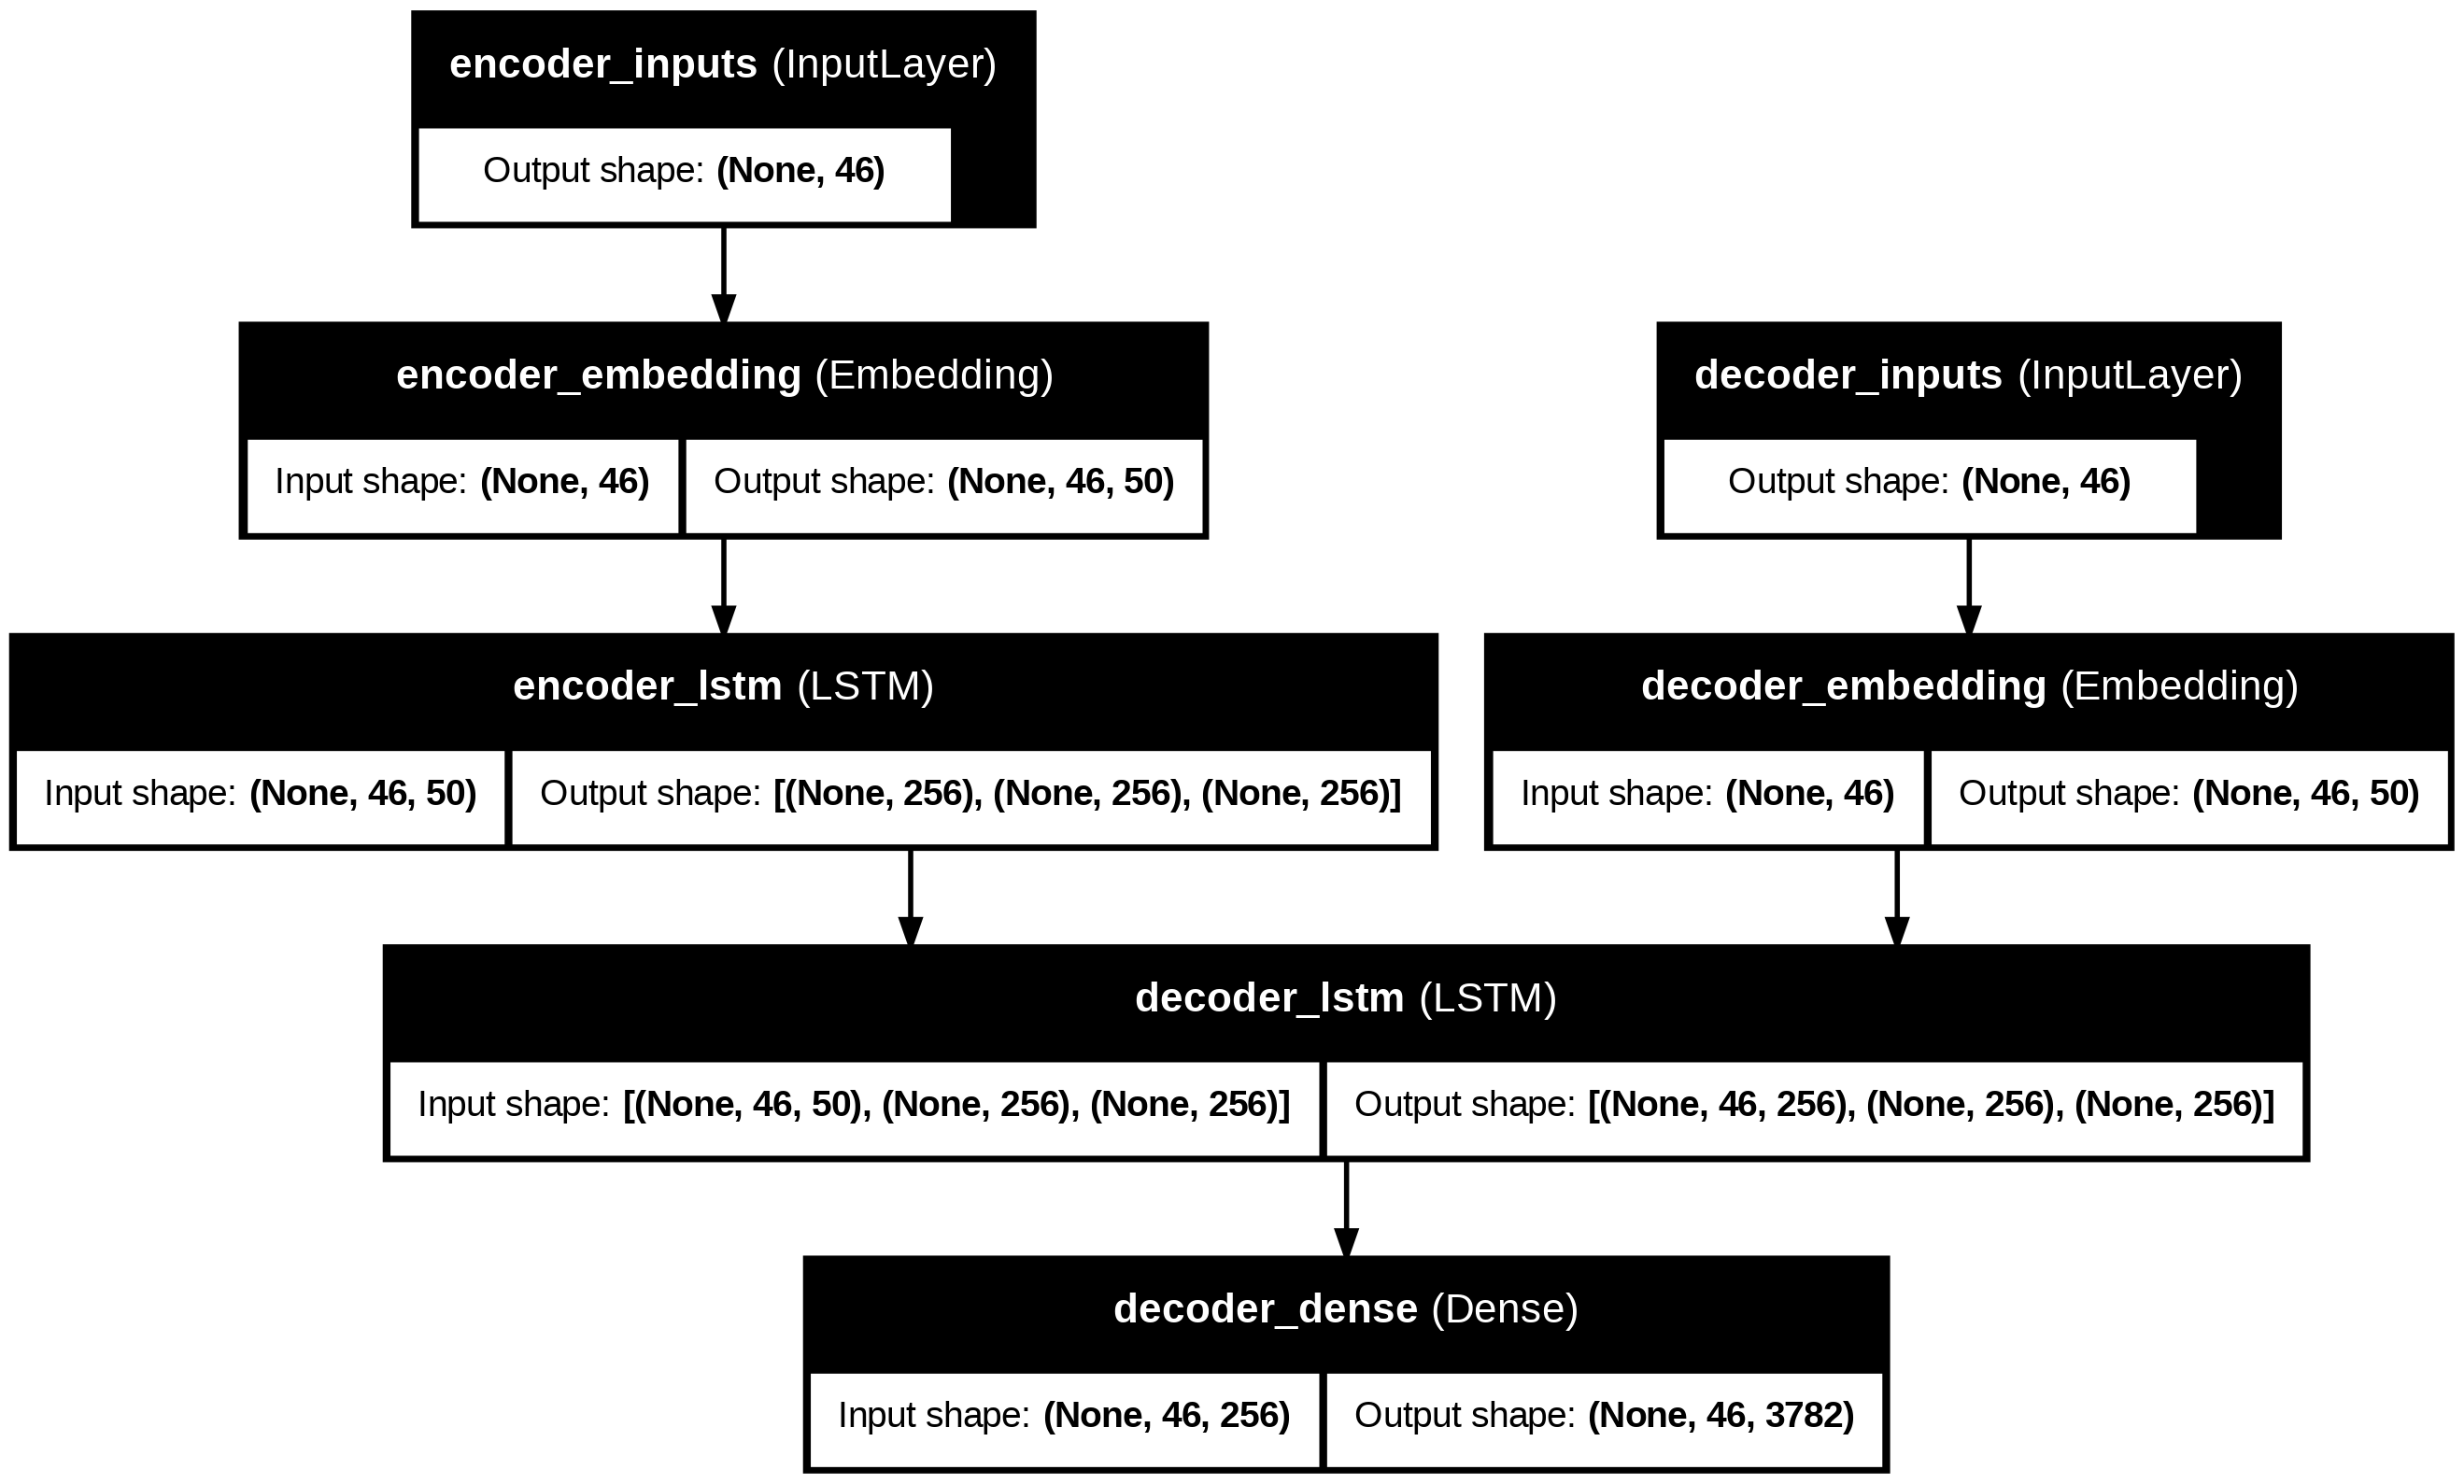

In [36]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Modelo encoder

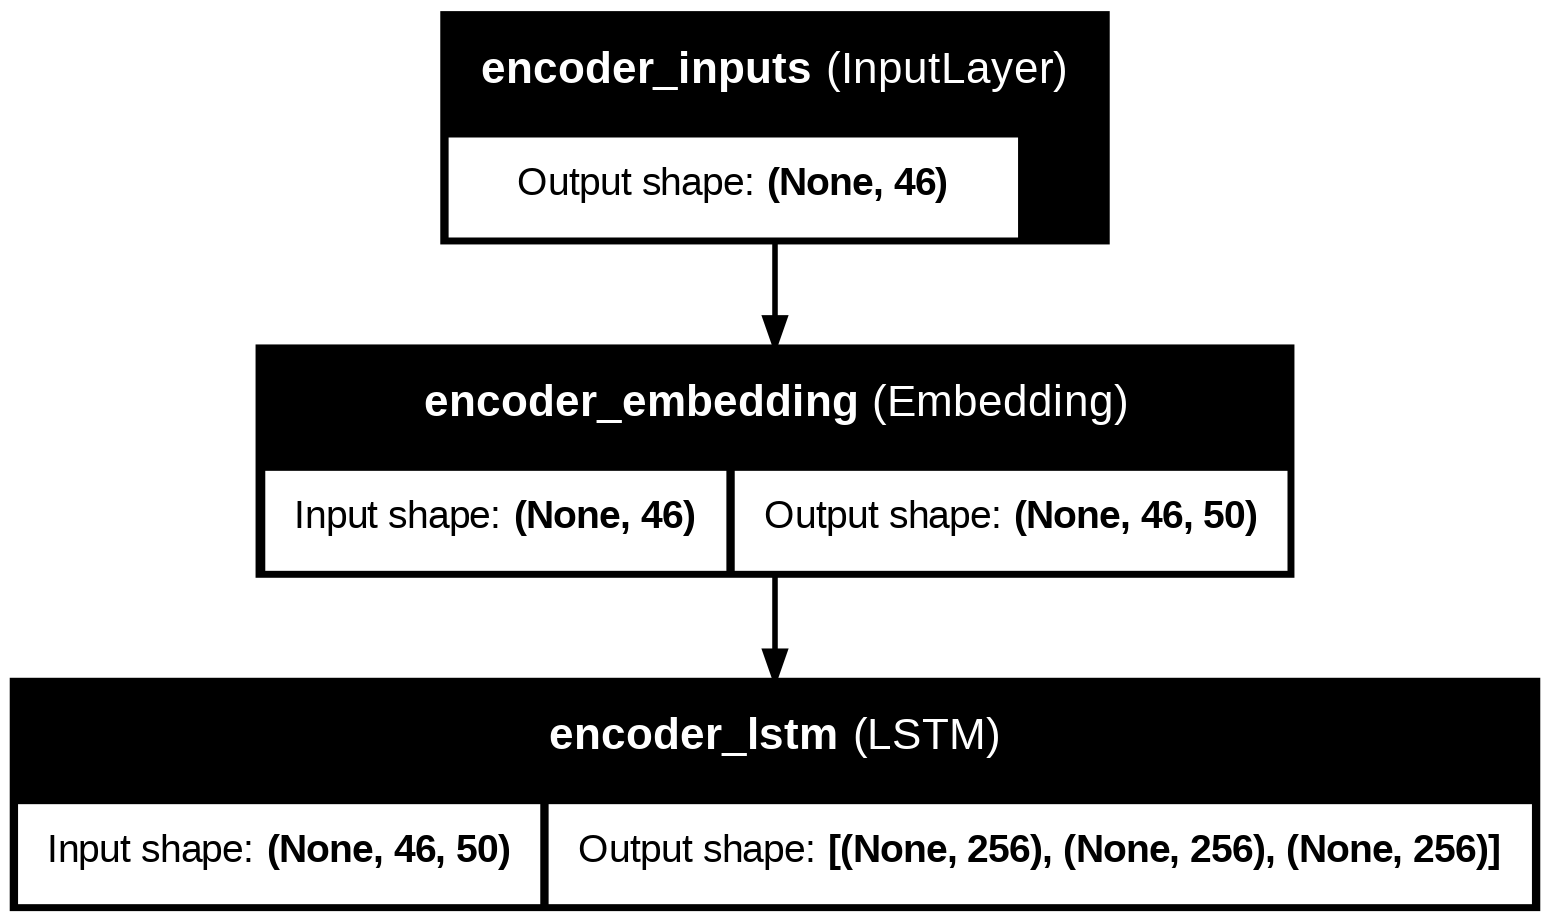

In [37]:
encoder_inputs = model.input[0]

encoder_outputs, state_h_enc, state_c_enc = model.get_layer('encoder_lstm').output
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

### Modelo decoder

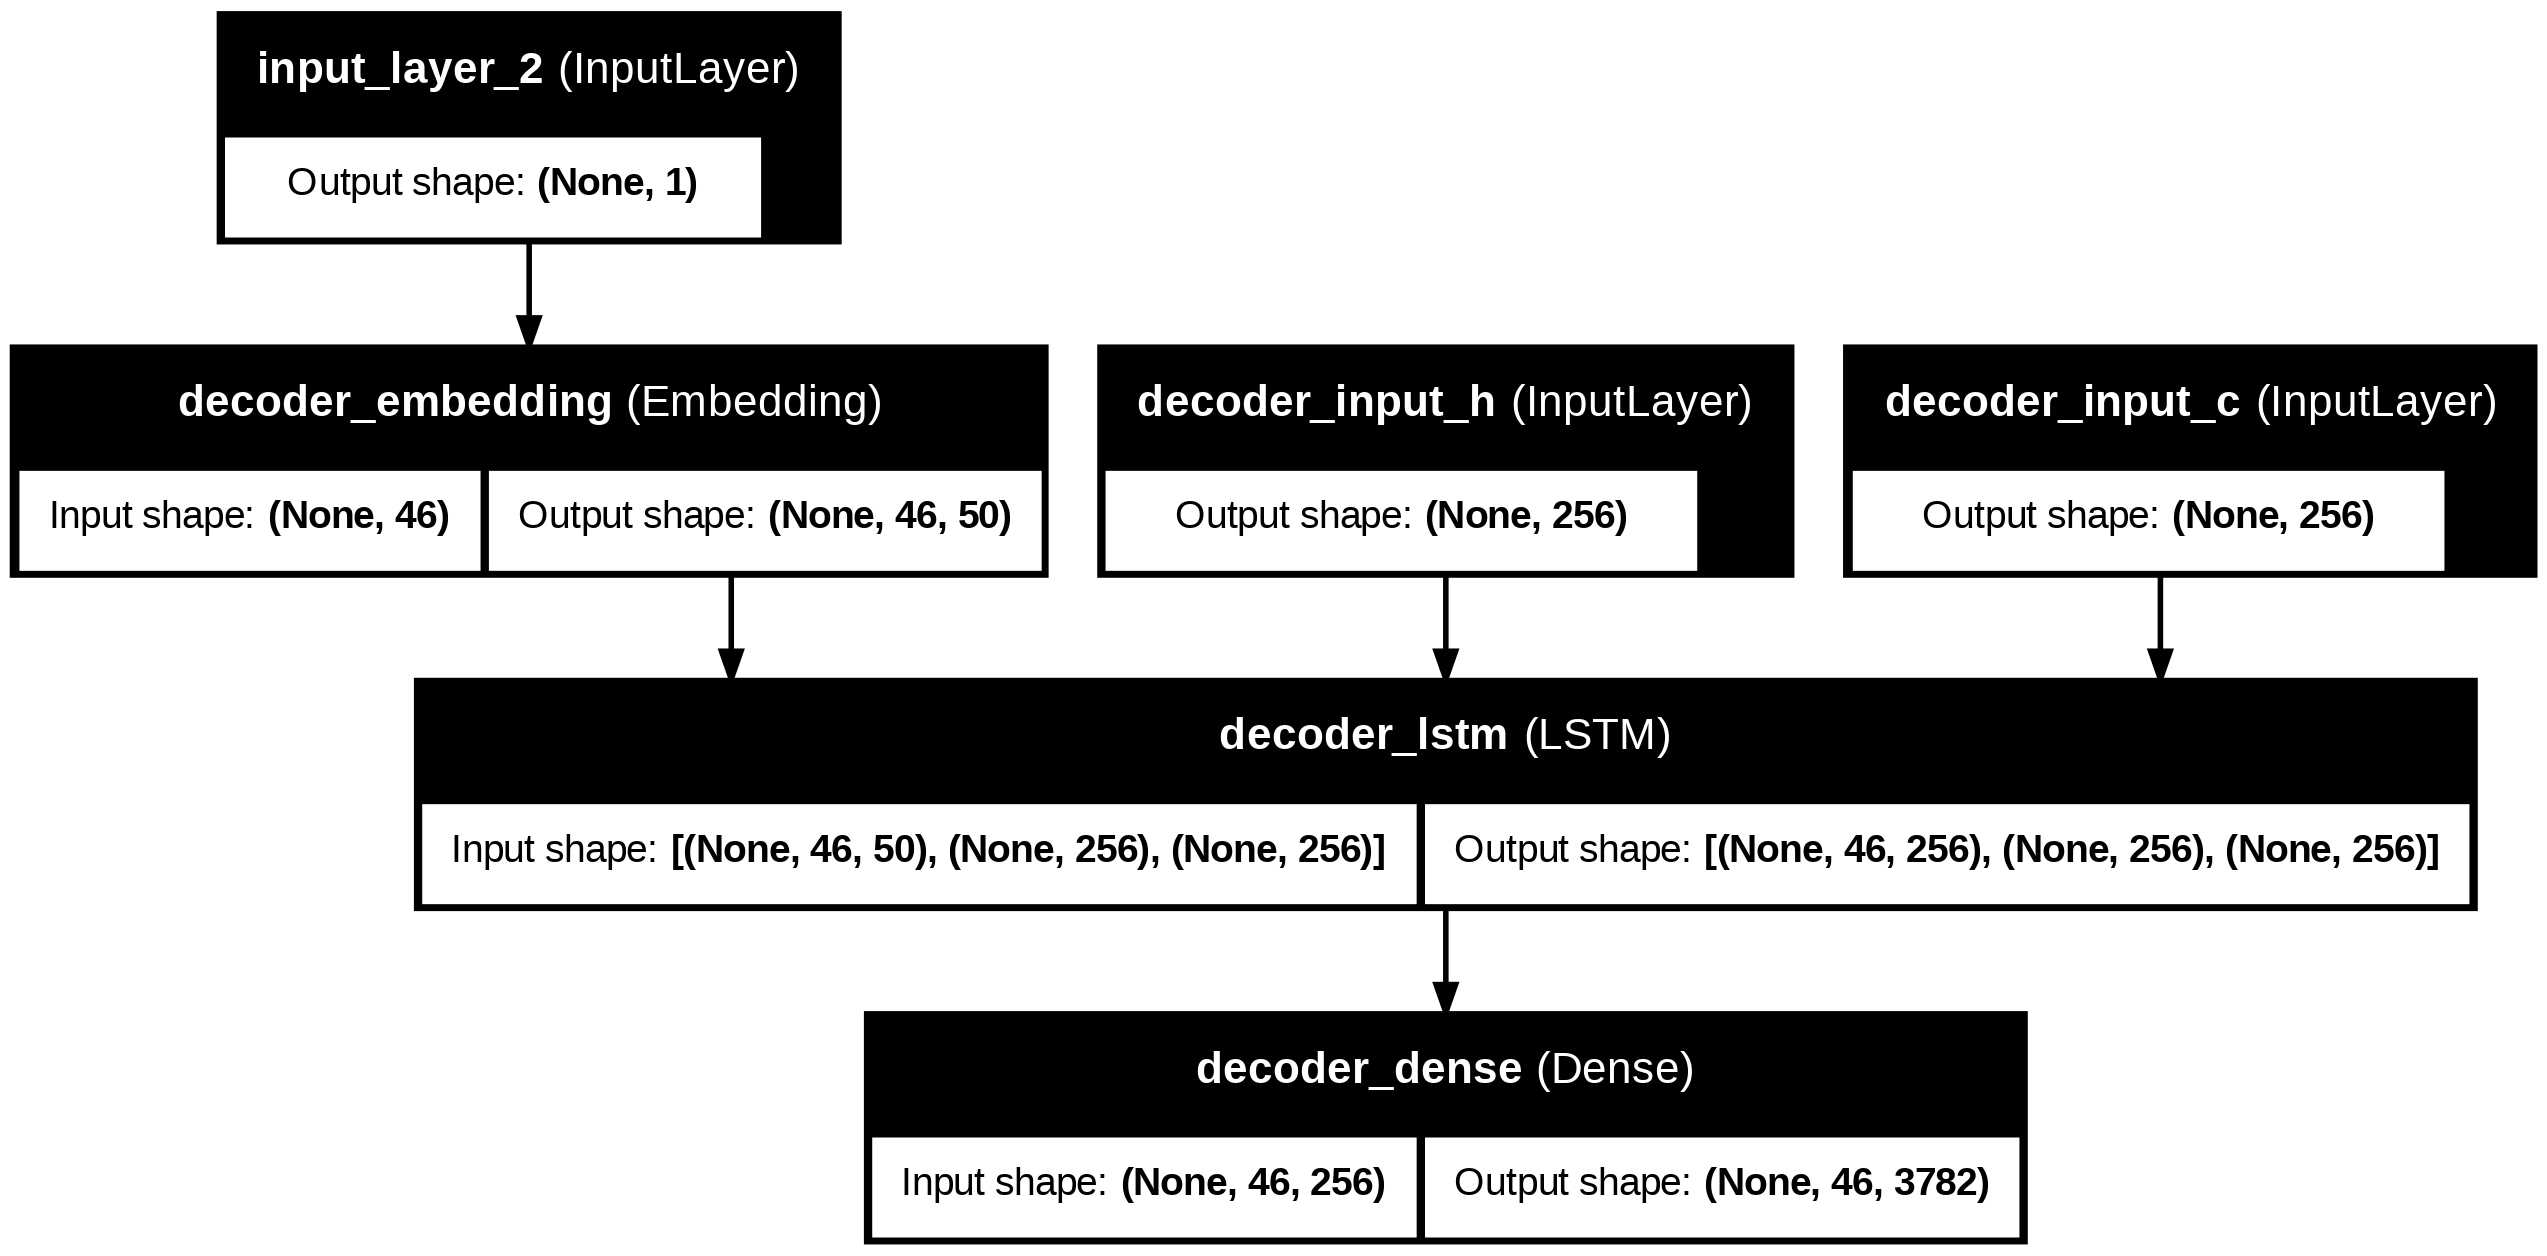

In [42]:
decoder_state_input_h = Input(shape=(256,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(256,), name='decoder_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))

decoder_embedding_layer = model.get_layer('decoder_embedding')
decoder_lstm = model.get_layer('decoder_lstm')
decoder_dense = model.get_layer('decoder_dense')

decoder_embedded_inputs = decoder_embedding_layer(decoder_inputs_single)

# Ejecutar el LSTM con los estados anteriores
decoder_outputs2, state_h_dec, state_c_dec = decoder_lstm(
    decoder_embedded_inputs, initial_state=decoder_states_inputs
)

decoder_states2 = [state_h_dec, state_c_dec]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)


In [39]:
import numpy as np

batch_size = 64
epochs = 50

history = model.fit(
    [encoder_input_seq, decoder_output_input_seq],
    decoder_targets,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8185 - loss: 2.5293 - val_accuracy: 0.8906 - val_loss: 0.6846
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8861 - loss: 0.6795 - val_accuracy: 0.9076 - val_loss: 0.5846
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9072 - loss: 0.5628 - val_accuracy: 0.9161 - val_loss: 0.5217
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9154 - loss: 0.4999 - val_accuracy: 0.9221 - val_loss: 0.4775
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9216 - loss: 0.4507 - val_accuracy: 0.9256 - val_loss: 0.4491
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9265 - loss: 0.4098 - val_accuracy: 0.9300 - val_loss: 0.4166
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9308 - loss: 0.3740 - val_accuracy: 0.9327 - val_loss: 0.3958
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9344 - loss: 0.3464 - val_acc

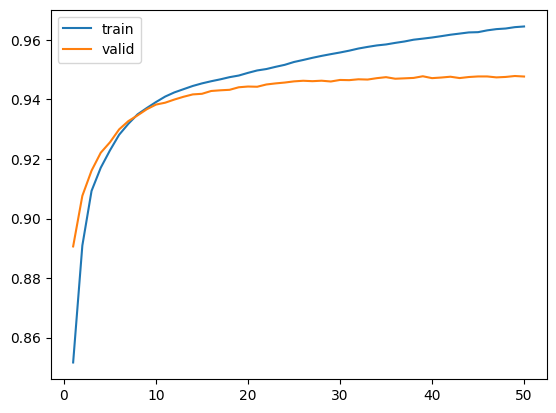

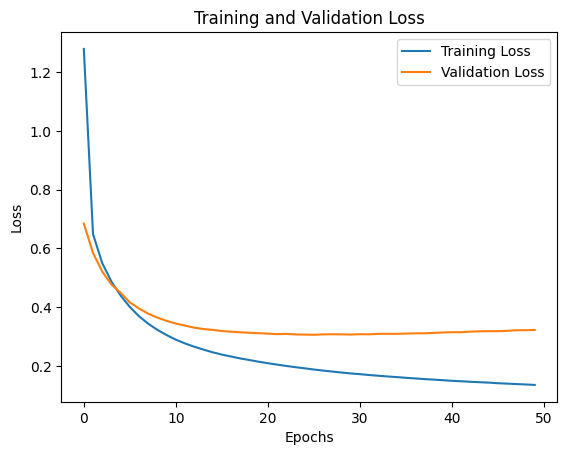

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Inferencia

In [46]:
# Parámetros
max_encoder_seq_length = 20
max_decoder_seq_length = 30
start_token_idx = word2idx_outputs.get('<sos>')
stop_token_idx = word2idx_outputs.get('<eos>')
idx2word_decoder = {idx: word for word, idx in word2idx_outputs.items()}


print(start_token_idx, stop_token_idx)

while True:
    user_input = input("You: ")

    if user_input.lower() in ['exit', 'quit', 'bye']:
        print("Bot: Bye!")
        break

    question_seq = preprocess_question(
        user_input,
        tokenizer_encoder,
        MAX_INPUT_LEN
    )
    response = generate_answer(
        encoder_model=encoder_model,
        decoder_model=decoder_model,
        question_seq=question_seq,
        max_decoder_seq_length=max_decoder_seq_length,
        start_token_idx=start_token_idx,
        stop_token_idx=stop_token_idx,
        idx2word=idx2word_decoder
    )
    print(f"Bot: {response}")

1940 1
You: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[[2.3963733e-04 4.1643900e-01 4.4416003e-02 ... 1.0331570e-07
   1.1886937e-07 9.8028394e-08]]]
1
{1: '<eos>', 2: 'i', 3: 'you', 4: 'do', 5: 'a', 6: 'what', 7: 'to', 8: 'like', 9: 'is', 10: 'are', 11: 'am', 12: 'have', 13: 'for', 14: 'how', 15: 'love', 16: 'that', 17: 'm', 18: 'the', 19: 'my', 20: 'it', 21: 'of', 22: 'your', 23: 'living', 24: 'in', 25: 'not', 26: 'and', 27: 'about', 28: 'any', 29: 'oh', 30: 'work', 31: 'good', 32: 'from', 33: 's', 34: 'yes', 35: 't', 36: 'no', 37: 'me', 38: 'hello', 39: 'favorite', 40: 'hobbies', 41: 'just', 42: 'read', 43: 'hi', 44: 'doing', 45: 'well', 46: 'with', 47: 'play', 48: 'cool', 49: 'don', 50: 'music', 51: 'go', 52: 'fun', 53: 'u', 54: 'so', 55: 'too', 56: 'at', 57: 'great', 58: 'lot', 59: 'but', 60: 'name', 61: 'ok', 62: 'today', 63: 'where', 64: 'live', 65: 'can', 66: 'kind', 67: 'know', 68: 'time', 69: 'see', 70: 'nice', 71: 'job', 72: 'be', 73:

### Conclusiones

Luego de agregar un dropout a la capa LSTM, la predicción continuá realizando mal ya que siempre devuelve 1 es posbile que la argmax este ocasionando este comportamiento lo cual la respuesta es siempre vacia al usar idx2word.get.